(page:oxidation_state)=
# (Simplified) Oxidation State Analysis

This script performs a simplified oxidation state analysis by calculating the ratio between the number of metal-metal and metal-oxygen bonds. Adapted from Hong and van Duin: [`J. Phys. Chem. C 2015, 119, 17876-17886.`](https://doi.org/10.1021/acs.jpcc.5b04650) This method is closely related to the [classical coordination number analysis](page:cns). However, in the present approach the coordination numbers are evaluated as a normalized density with respect to the geometric center of the structure.

In this example, we analyze a surface-oxidized structure that still has a metallic core - a Pt / Pt-O core-shell nanoparticle. We define that Pt atoms that have 100 % Pt neighbors as being in the "metallic" state. Similarly, "surface oxide" is defined to correspond to between 75 and 99 % Pt neighbors, "subsurface oxide" between 25 and 74 % Pt neighbors, and a "bulk oxide" is indicated if a Pt atom has < 24 % Pt neighbors.

Note that in this implementation, we calculate the neighbor ratio for each Pt atom as (number of O neighbors / total number of neighbors). This means that undercoordinated atoms at the facets, edges, and vertices also count as fully metallic if no oxygen atoms are present in their vicinity, even though these atoms are not fully saturated in terms of coordination. This behavior may not be desirable in all cases but can be changed easily by, for example, making the oxidation state assignment based on the Pt-Pt coordination number for each Pt atom instead of the aforementioned neighbor ratio.

First, retrieve the data that was read in and converted to a `.csv` file on the [setup page](page:setup).

In [1]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

From the data set, we'll pick a structure that is somewhat (but not fully) oxidized, containing 400 oxygen atoms, corresponding to a core-shell nanoparticle as outlined above. Then, read the associated `.bgf` into an `ase.Atoms` object.

In [2]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 400)].iloc[0]
atoms = read_bgf(sample["root"])

Let's visualize the structure we have chosen. As discussed [earlier](page:gcns), the `x3d` viewer is a bit simplistic and we need to transform the system's coordinates to display it properly. Make a copy of the original `ase.Atoms` object since we need the unmodified structure below. Apply a cutting plane to showcase the core-shell nature of the particle.

In [3]:
from ase.visualize import view

viewatoms = atoms.copy()
center = viewatoms.cell.diagonal() / 2
viewatoms.translate((-1) * center)
viewatoms.translate([0,0,-38])

# Apply a cutting plane through the particle.
com = viewatoms.get_center_of_mass()
select = [viewatoms.index for viewatoms in viewatoms if viewatoms.position[2] < com[2] + 0.3]

view(viewatoms[select], viewer="x3d")

This oxidation state analysis works exclusively based on analyzing the chemical environment. Therefore, and similar to the [coordination number analysis](page:cns), we will determine a neighbor list. To this end, we need to define a cutoff value $r_\mathrm{c}$ used to define at which distance two atoms will be considered neighbors. 3.0 Å presents a good trade-off that catches both Pt-Pt and Pt-O bonds.

In [4]:
rc = 3.0

Here, we will analyze the chemical environment of Pt atoms to approximate their oxidation state from the ratio between Pt-Pt and Pt-O bonds. We therefore need to filter by Pt atoms as the probe.

In [5]:
probe = "Pt"

The final analysis will be a radial distribution where the distance from the center of the particle, $r$, will be shown on the $x$ axis and the number of atoms with a particular (approximate) oxidation state will be shown on the $y$ axis. The analysis will be discretized with regards to $r$. Here, we choose an appropriate bin width (~ $\Delta r$) for the $r$ increments.

In [6]:
binwidth = 0.2

The next code cell is familiar from the [generalized coordination number analysis](page:gcns). For each atom that is of type `probe`, we determine the atomic indices of its neighbors (including elements that are not of type `probe` - this is important later on!). The results are collected in a `dictionary`. 

In [7]:
indices = [atom.index for atom in atoms if atom.symbol == probe]
neighborList = {}
for idx in indices:

    # Calculate distances to ALL other atoms.
    allDists = atoms.get_distances(idx, [atom.index for atom in atoms])

    # Initialize empty list for current atom index.
    neighborList.update({idx: []})

    # Add indices of neighbor atoms to the list.
    for i, d in enumerate(allDists):
        if d > 0 and d <= rc:
            neighborList[idx].append(atoms[i].index)

```{tip} This is the third time that we implement a somwhat similar neighbor list function, see also the pages for [coordination numbers](page:cns) and [generalized coordination numbers](page:gcns). In production code, this function should be implemented in a generalized fashion and then reused in these different scenarios. Minimizing code repetition not only reduces code clutter and improves legibility, it also makes software easier to debug and upgrade since changes only need to be made in one place!
```

As mentioned before, we ultimately want to show a distribution of oxidation numbers as a function of $r$, the distance from the center of the analyzed cluster. To this end, we first need to find the center of the structure as the origin for our analysis coordinate system.

The geometric center of a structure is the average of all atomic positions. First, separately sum over all $x$, $y$, and $z$ values of all atomic positions.

The following code cells will make use of some very light `numpy` vectorization, specifically the `numpy.sum` function that will perform a sum over a list or `numpy` array.

`numpy.sum` with the `axis=0` argument will sum vectors in column-wise fashion (we will visualize this below). `ase.Atoms.get_positions` yields a `numpy` array where all positions are arrays themselves that hold the $x$, $y$, and $z$ coordinates. The position arrays are all stacked on top of each other, like so: 

In [8]:
print(atoms.get_positions())

[[14.37887 28.15738 29.95687]
 [14.71018 30.99521 28.80576]
 [13.12959 30.45461 31.29882]
 ...
 [35.61784 36.74153 38.90318]
 [33.32736 37.39523 33.60705]
 [43.13302 25.6283  26.83266]]


`axis = 0` will now force `numpy.sum` to calculate the sum along each **column**:

In [9]:
import numpy as np

sum_xyz = np.sum(atoms.get_positions(), axis=0)
print(sum_xyz)

[27289.50314 27172.34412 27435.40507]


The output, therefore, is a single vector where the entries are the sums over all $x$, $y$, and $z$ coordinates. Compare this to the default output of `numpy.sum` (where `axis = 1` is implied):

In [10]:
print(np.sum(atoms.get_positions()))

81897.25232999999


With the (default) `axis = 1` setting, `numpy` will sum along the **rows**, across all arrays, giving just a single floating point number as the result. Of course, this number is exactly the same as summing up the three components of the `sum_xyz` vector above!

After this short tangent, let's get back to calculating the geometric center of the structure. All that's left to do is to divide `sum_xyz` by the number of atoms to obtain the geometric center of the structure.

In [11]:
center = sum_xyz / len(atoms)
print(center)

[30.69685393 30.5650665  30.86097308]


In the next step, we need to calculate the distance between the geometric center and every `probe` atom. (Remember the `indices` list from above? It holds indices of the relevant atoms, we can reuse it here.) We also make use of a straight-forward `numpy` broadcasting operation: we exploit that the if we execute the operation [array of numpy vectors]  - [numpy vector], `numpy` will automatically subtract the latter vector from every vector in the former array. 

Finally, we use `numpy.linalg.norm` to calculate the norm of the distance vectors, *i.e.*, the Euclidian distance. This time, we set `axis = 1` to tell the function to calculate the norm along each row-wise element instead of for the columns.

In [12]:
dists = np.linalg.norm(atoms[indices].get_positions() - center, axis=1)

Next we need to find the largest distance in the data set.

In [13]:
dmax = max(dists)
print(dmax)

19.457417708152864


Based on the bin width defined above and the maximum distance, we can now determine the number of distance bins we will end up with.

In [14]:
nbins = int(dmax / binwidth)

We can now initialize (empty) results lists for the various oxidation states we intend to calculate.

In [15]:
metallic = [0] * (nbins + 1)
surface = [0] * (nbins + 1)
subsurface = [0] * (nbins + 1)
oxide = [0] * (nbins + 1)

print(metallic)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The (somewhat arbitrary) convention we will use here is:
* Metallic: 100 % Pt neighbors
* Surface oxide: 74 - 99 % Pt neighbors.
* Subsurface oxide: 25 - 74 % Pt neighbors.
* Fully oxidized: < 24 % Pt neighbors.

```{tip} Here, we hard-code which types of oxides are considered. Have a look at how this method is generalized in the [asetools implementation](https://gitlab.com/bjk24/asetools/-/blob/main/asetools/analysis/oxidationStates.py) where users can supply any number of different oxidation states.
```  

Now loop through all atoms of type `probe` and see which distance bin they fall into. We will make use of the knowledge that the `dists` array and the `indices` list have a 1:1 correlation. Furthermore, we calculate the ratio of [neighbors that are not probe] / [total number of neighbors] to find out into which of the oxidation state categories outlined above the current atom falls into.

In [16]:
for i, idx in enumerate(indices):
    dist = dists[i]
    thisbin = int(dist / binwidth)
    if thisbin <= nbins:
        cntO = len([nidx for nidx in neighborList[idx] if atoms[nidx].symbol != probe])
        ratio = cntO / len(neighborList[idx])
        if ratio == 0:
            metallic[thisbin] += 1
        if ratio > 0 and ratio <= 0.25:
            surface[thisbin] += 1
        if ratio > 0.25 and ratio <= 0.75:
            subsurface[thisbin] += 1
        if ratio > 0.75:
            oxide[thisbin] += 1

Next, normalize each bin in the collection lists by the volume of the sphere segment with width `binwidth` that they respresent. This process converts the results from a simple frequency to a number density. 

Analyzing the density is often desirable when dealing with radial distributions because the volume of each subsequent sphere segment is larger than the previous and therefore can hold more total atoms. The absolute frequency of oxidation states, therefore, increases with increasing $r$. 

In [17]:
for i, ibin in enumerate(metallic):
    metallic[i] = ibin / ((i + 1) * 4 / 3 * np.pi * binwidth**3)
for i, ibin in enumerate(surface):
    surface[i] = ibin / ((i + 1) * 4 / 3 * np.pi * binwidth**3)
for i, ibin in enumerate(subsurface):
    subsurface[i] = ibin / ((i + 1) * 4 / 3 * np.pi * binwidth**3)
for i, ibin in enumerate(oxide):
    oxide[i] = ibin / ((i + 1) * 4 / 3 * np.pi * binwidth**3)

Finally, we can visualize the results. On the $x$ axis we will show the reduced distance, $r^* = \frac{r}{dmax}$, just like in the [publication](https://doi.org/10.1021/acs.jpcc.5b04650) that this analysis was adapted from.

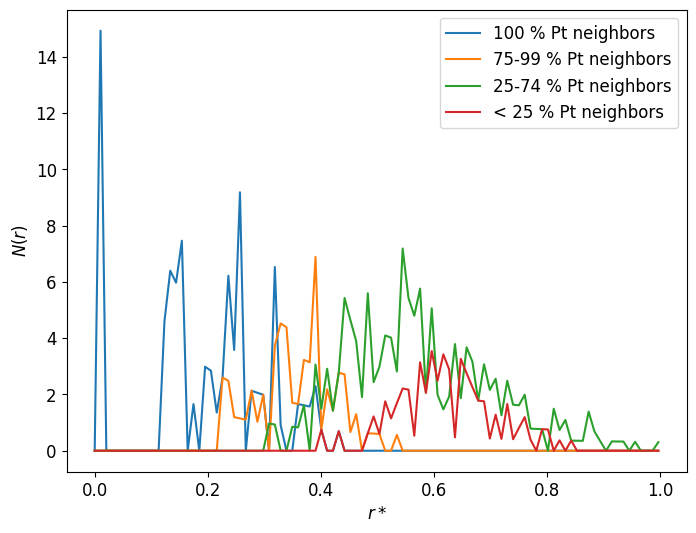

In [18]:
import matplotlib.pyplot as plt

x = [i * binwidth / dmax for i in range(nbins + 1)]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(x, metallic, label = "100 % Pt neighbors")
plt.plot(x, surface, label = "75-99 % Pt neighbors")
plt.plot(x, subsurface, label = "25-74 % Pt neighbors")
plt.plot(x, oxide, label = "< 25 % Pt neighbors")
plt.xlabel("$r*$")
plt.ylabel("$N(r)$")
plt.legend()
plt.show()

The analysis nicely shows how the oxidation progresses into the particle, with the core remaining metallic.